date: 2023-01-15 00:00:00
times: DatetimeIndex(['2023-01-15 00:00:00+08:00', '2023-01-15 00:01:00+08:00',
               '2023-01-15 00:02:00+08:00', '2023-01-15 00:03:00+08:00',
               '2023-01-15 00:04:00+08:00', '2023-01-15 00:05:00+08:00',
               '2023-01-15 00:06:00+08:00', '2023-01-15 00:07:00+08:00',
               '2023-01-15 00:08:00+08:00', '2023-01-15 00:09:00+08:00',
               ...
               '2023-01-15 23:51:00+08:00', '2023-01-15 23:52:00+08:00',
               '2023-01-15 23:53:00+08:00', '2023-01-15 23:54:00+08:00',
               '2023-01-15 23:55:00+08:00', '2023-01-15 23:56:00+08:00',
               '2023-01-15 23:57:00+08:00', '2023-01-15 23:58:00+08:00',
               '2023-01-15 23:59:00+08:00', '2023-01-16 00:00:00+08:00'],
              dtype='datetime64[ns, Asia/Hong_Kong]', length=1441, freq='T')
hour: 6
Empty DataFrame
Columns: [apparent_zenith, zenith, apparent_elevation, elevation, azimuth, equation_of_time]
Index: []
hour: 7
     

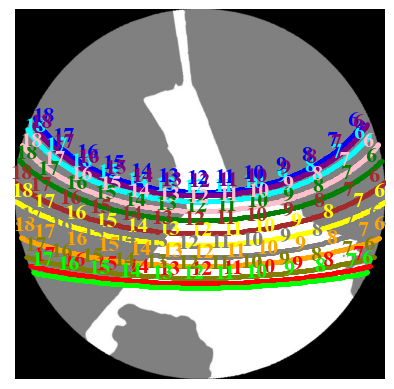

In [3]:
import pandas as pd
import math
import numpy as np
from pvlib import solarposition
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

# 设置 Matplotlib 的全局字体大小
# plt.rcParams.update({'font.size': 24})

lat = 22.28422469  # 京士柏气象站的纬度
long = 114.13959853  # 京士柏气象站的经度
tz = 'Asia/Hong_Kong'
list_hour = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

# 用于存储每个月的太阳轨迹坐标数据
all_merged_list_x = []
all_merged_list_y = []

for month in range(1, 13):  # 循环12个月，从1月到12月
    merged_list_x = []
    merged_list_y = []
    date_str = f'2023-{month:02d}-15'  # 构造每个月15号的日期字符串
    date = pd.to_datetime(date_str)
    print("date:", date)
    times = pd.date_range(date, date + pd.Timedelta('24h'), freq='1min', tz=tz)
    print("times:", times)
    solpos_all = solarposition.get_solarposition(times, lat, long)
    solpos = solpos_all.loc[solpos_all['apparent_elevation'] > 0, :]  # 筛选掉太阳高度角太小的点
    for hour in range(len(list_hour)):  # 逐小时计算太阳持续时间 考虑遮挡情况
        hour = list_hour[hour]
        print("hour:", hour)
        subset = solpos.loc[solpos.index.hour == hour, :]
        print(subset)
        if not subset.empty:
            length = int(len(subset))

            azimuth = np.radians(subset.azimuth)  # 太阳方位角
            zenith = subset.apparent_zenith  # 太阳天顶角

            # zenith = subset.iloc[math.floor((length / 2)), 0]
            # azimuth = subset.iloc[math.floor((length / 2)), 4]

            x = (326 / 90 * zenith * np.sin(azimuth)) + 326  # 横坐标 这里是鱼眼图边长/2
            y = (326 / 90 * zenith * np.cos(azimuth)) + 326
            # 调转日出方向（东西）
            # x = x + 2 * (326 - x)

            list_x1 = x.values.tolist()  # 转为列表存储
            list_y1 = y.values.tolist()
            # 四舍五入
            list_x = [round(x) for x in list_x1]
            list_y = [round(y) for y in list_y1]

            merged_list_x.extend(list_x)
            merged_list_y.extend(list_y)
    all_merged_list_x.append(merged_list_x)
    all_merged_list_y.append(merged_list_y)

# 设置Times New Roman字体
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16  # 根据需要调整字体大小

# 加载图像并处理
img = Image.open(r'C:\Users\wac\Desktop\fx\img\fisheye_sky2\000216_22.23799695_114.15296303_202203_7_306.jpg')
img = np.array(img.transpose(Image.FLIP_TOP_BOTTOM))  # 上下翻转

# 转换图像为RGB
img_rgb = img[:, :, :3]  # 假设图像是RGB格式

plt.imshow(img)

# 绘制12个月的太阳轨迹点，使用不同颜色区分不同月份（简单示例用颜色列表区分）
colors = ['red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'purple', 'pink', 'brown', 'gray', 'olive', 'lime']
for i in range(12):
    plt.scatter(all_merged_list_x[i], all_merged_list_y[i], color=colors[i], marker='o', s=5)

# 添加每小时的间隔文字（针对每个月的轨迹都添加）
for month in range(12):
    for hour in list_hour:
        # 根据小时筛选对应月份的太阳位置数据
        date_str = f'2023-{month + 1:02d}-15'
        date = pd.to_datetime(date_str)
        times = pd.date_range(date, date + pd.Timedelta('24h'), freq='1min', tz=tz)
        solpos_all = solarposition.get_solarposition(times, lat, long)
        solpos = solpos_all.loc[solpos_all['apparent_elevation'] > 0, :]
        subset = solpos.loc[solpos.index.hour == hour, :]
        if not subset.empty:
            middle_idx = len(subset) // 2
            zenith = subset.iloc[middle_idx].apparent_zenith
            azimuth = subset.iloc[middle_idx].azimuth

            # 计算文本位置，确保它位于太阳轨迹点的正上方
            x_text = (326 / 90 * zenith * np.sin(np.radians(azimuth))) + 326
            y_text = (326 / 90 * zenith * np.cos(np.radians(azimuth))) + 326 + 7  # 减去10作为偏移量

            # 绘制文本，垂直对齐方式设置为'bottom'
            plt.text(x_text, y_text, f'{hour}', fontsize=16, fontweight='bold', ha='center', va='bottom',
                     color=colors[month])

# 设置坐标轴范围
plt.xlim(0, 652)
plt.ylim(0, 652)
# 使用plt.savefig()并指定参数
plt.axis('off')
plt.savefig(r'C:\Users\wac\Desktop\fx\img\fisheye_sky2\results1.jpg', dpi=300, bbox_inches='tight')

# 显示图像和点
plt.show()

date: 2023-01-15 00:00:00
times: DatetimeIndex(['2023-01-15 00:00:00+08:00', '2023-01-15 00:01:00+08:00',
               '2023-01-15 00:02:00+08:00', '2023-01-15 00:03:00+08:00',
               '2023-01-15 00:04:00+08:00', '2023-01-15 00:05:00+08:00',
               '2023-01-15 00:06:00+08:00', '2023-01-15 00:07:00+08:00',
               '2023-01-15 00:08:00+08:00', '2023-01-15 00:09:00+08:00',
               ...
               '2023-01-15 23:51:00+08:00', '2023-01-15 23:52:00+08:00',
               '2023-01-15 23:53:00+08:00', '2023-01-15 23:54:00+08:00',
               '2023-01-15 23:55:00+08:00', '2023-01-15 23:56:00+08:00',
               '2023-01-15 23:57:00+08:00', '2023-01-15 23:58:00+08:00',
               '2023-01-15 23:59:00+08:00', '2023-01-16 00:00:00+08:00'],
              dtype='datetime64[ns, Asia/Hong_Kong]', length=1441, freq='T')
hour: 6
Empty DataFrame
Columns: [apparent_zenith, zenith, apparent_elevation, elevation, azimuth, equation_of_time]
Index: []
hour: 7
     

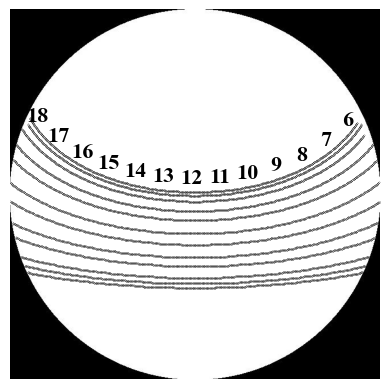

In [14]:
import pandas as pd
import math
import numpy as np
from pvlib import solarposition
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

# 设置 Matplotlib 的全局字体大小
# plt.rcParams.update({'font.size': 24})

lat = 22.28422469  # 京士柏气象站的纬度
long = 114.13959853  # 京士柏气象站的经度
tz = 'Asia/Hong_Kong'
list_hour = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

# 用于存储每个月的太阳轨迹坐标数据
all_merged_list_x = []
all_merged_list_y = []

for month in range(1, 13):  # 循环12个月，从1月到12月
    merged_list_x = []
    merged_list_y = []
    date_str = f'2023-{month:02d}-15'  # 构造每个月15号的日期字符串
    date = pd.to_datetime(date_str)
    print("date:", date)
    times = pd.date_range(date, date + pd.Timedelta('24h'), freq='1min', tz=tz)
    print("times:", times)
    solpos_all = solarposition.get_solarposition(times, lat, long)
    solpos = solpos_all.loc[solpos_all['apparent_elevation'] > 0, :]  # 筛选掉太阳高度角太小的点
    for hour in range(len(list_hour)):  # 逐小时计算太阳持续时间 考虑遮挡情况
        hour = list_hour[hour]
        print("hour:", hour)
        subset = solpos.loc[solpos.index.hour == hour, :]
        print(subset)
        if not subset.empty:
            length = int(len(subset))

            azimuth = np.radians(subset.azimuth)  # 太阳方位角
            zenith = subset.apparent_zenith  # 太阳天顶角

            # zenith = subset.iloc[math.floor((length / 2)), 0]
            # azimuth = subset.iloc[math.floor((length / 2)), 4]

            x = (326 / 90 * zenith * np.sin(azimuth)) + 326  # 横坐标 这里是鱼眼图边长/2
            y = (326 / 90 * zenith * np.cos(azimuth)) + 326
            # 调转日出方向（东西）
            # x = x + 2 * (326 - x)

            list_x1 = x.values.tolist()  # 转为列表存储
            list_y1 = y.values.tolist()
            # 四舍五入
            list_x = [round(x) for x in list_x1]
            list_y = [round(y) for y in list_y1]

            merged_list_x.extend(list_x)
            merged_list_y.extend(list_y)
    all_merged_list_x.append(merged_list_x)
    all_merged_list_y.append(merged_list_y)

# 设置Times New Roman字体
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16  # 根据需要调整字体大小

# 加载图像并处理
img = Image.open(r'D:\paper1\2-实验流程\6-鱼眼图像叠加天空轨迹\叠加\天空图的背景\black_background_with_white_circle.jpg')
img = np.array(img.transpose(Image.FLIP_TOP_BOTTOM))  # 上下翻转

# 转换图像为RGB
img_rgb = img[:, :, :3]  # 假设图像是RGB格式

plt.imshow(img)

# 绘制12个月的太阳轨迹点，使用不同颜色区分不同月份（简单示例用颜色列表区分）
colors = ['black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black']
for i in range(12):
    plt.scatter(all_merged_list_x[i], all_merged_list_y[i], color=colors[i], marker='o', s=0.02)
for month in range(1):
    for hour in list_hour:
        # 根据小时筛选对应月份的太阳位置数据
        date_str = f'2023-6-15'
        date = pd.to_datetime(date_str)
        times = pd.date_range(date, date + pd.Timedelta('24h'), freq='1min', tz=tz)
        solpos_all = solarposition.get_solarposition(times, lat, long)
        solpos = solpos_all.loc[solpos_all['apparent_elevation'] > 0, :]
        subset = solpos.loc[solpos.index.hour == hour, :]
        if not subset.empty:
            middle_idx = len(subset) // 2
            zenith = subset.iloc[middle_idx].apparent_zenith
            azimuth = subset.iloc[middle_idx].azimuth

            # 计算文本位置，确保它位于太阳轨迹点的正上方
            x_text = (326 / 90 * zenith * np.sin(np.radians(azimuth))) + 326
            y_text = (326 / 90 * zenith * np.cos(np.radians(azimuth))) + 326 + 7  # 减去10作为偏移量

            # 绘制文本，垂直对齐方式设置为'bottom'
            plt.text(x_text, y_text, f'{hour}', fontsize=16, fontweight='bold', ha='center', va='bottom',
                     color=colors[month])

# 设置坐标轴范围
plt.xlim(0, 652)
plt.ylim(0, 652)
# 使用plt.savefig()并指定参数
plt.axis('off')
plt.savefig(r'D:\paper1\2-实验流程\6-鱼眼图像叠加天空轨迹\叠加\天空图叠加轨迹\天空图叠加轨迹.jpg', dpi=300, bbox_inches='tight')

# 显示图像和点
plt.show()